In [1]:
import pandas as pd
import numpy as np
import os
import random
import joblib
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score,precision_recall_curve, average_precision_score
from xgboost import XGBClassifier

In [2]:
# Setting random seed to replicate results
DEFAULT_RANDOM_SEED = 2021

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)

seedEverything(2021)

In [3]:
# Load dataset
df = pd.read_csv('train.csv')  

# Convert labels
df['label'] = df['label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [4]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [5]:
features_to_drop = [
    'bwd psh flags', 'bwd urg flags', 'fwd avg bytes/bulk',
    'fwd avg packets/bulk', 'fwd avg bulk rate', 'bwd avg bytes/bulk',
    'bwd avg packets/bulk', 'bwd avg bulk rate', 'fwd header length.1'
]


df = df.drop(columns=features_to_drop)

Dropping columns with only single value

In [6]:
# Split features and labels
X = df.drop(columns=['label'])
y = df['label']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [8]:
from sklearn.feature_selection import RFE
#Feature selection using RFE
model = XGBClassifier()
rfe = RFE(estimator=model, n_features_to_select=10)
rfe.fit(X_train, y_train)

RFE(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, device=None,
                            early_stopping_rounds=None,
                            enable_categorical=False, eval_metric=None,
                            feature_types=None, gamma=None, grow_policy=None,
                            importance_type=None, interaction_constraints=None,
                            learning_rate=None, max_bin=None,
                            max_cat_threshold=None, max_cat_to_onehot=None,
                            max_delta_step=None, max_depth=None,
                            max_leaves=None, min_child_weight=None, missing=nan,
                            monotone_constraints=None, multi_strategy=None,
                            n_estimators=None, n_jobs=None,
                            num_parallel_tree=None, random_state=None, ...),
    n_features_to_select=10)

In [9]:
selected_features = X_train.columns[rfe.support_]

feature_ranking = pd.DataFrame({'Feature': X_train.columns, 'Ranking': rfe.ranking_})
print(feature_ranking)

                        Feature  Ranking
0              destination port        1
1                 flow duration       32
2             total fwd packets        6
3        total backward packets       28
4   total length of fwd packets       23
..                          ...      ...
64                   active min       29
65                    idle mean       44
66                     idle std       41
67                     idle max       24
68                     idle min       10

[69 rows x 2 columns]


In [10]:
print("Top 10 features")
print(selected_features)

Top 10 features
Index(['destination port', 'bwd packet length min', 'bwd packet length mean',
       'bwd packet length std', 'max packet length', 'psh flag count',
       'average packet size', 'init_win_bytes_backward',
       'min_seg_size_forward', 'active std'],
      dtype='object')


In [11]:
new_df = df[selected_features]
new_df['label'] = df['label']

C:\Users\akash\AppData\Local\Temp\ipykernel_9520\2569592695.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['label'] = df['label']


In [12]:
# Split features and labels
X = new_df.drop(columns=['label'])
y = new_df['label']

In [13]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=DEFAULT_RANDOM_SEED)

In [14]:
# Standardize features

scaler = StandardScaler()

exclude_columns = ['label']

numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns.difference(exclude_columns)

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [15]:
# Save scaler
joblib.dump(scaler, 'phase2scaler.pkl')

['phase2scaler.pkl']

Saving scaler to be used in dynamic part

In [16]:
def estimateResult(model,X,y,test_set,actual_vals,model_name):
    model.fit(X,y)
    result = model.predict(test_set)
    tn, fp, fn, tp = confusion_matrix(actual_vals, result).ravel()
    false_positive_rate = fp / (fp + tn)
    result_metrics = {
    "Model": model_name,
    "Accuracy": accuracy_score(actual_vals, result),
    "Precision": precision_score(actual_vals, result),
    "Recall": recall_score(actual_vals, result),
    "F1 Score": f1_score(actual_vals, result),
    "False Positive Rate": false_positive_rate}
    

    y_pred_prob = model.predict_proba(test_set)[:, 1]
    fpr, tpr, thresholds = roc_curve(actual_vals, y_pred_prob)
    auc_score = roc_auc_score(actual_vals, y_pred_prob)

    pyplot.figure(figsize=(8, 6))
    pyplot.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
    pyplot.plot([0, 1], [0, 1], linestyle='--', color='gray')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.title(f'ROC AUC Curve for {model_name}')
    pyplot.legend(loc='lower right')
    pyplot.show()

    precision, recall, _ = precision_recall_curve(actual_vals, y_pred_prob)
    avg_precision = average_precision_score(actual_vals, y_pred_prob)

    pyplot.figure(figsize=(8, 6))
    pyplot.plot(recall, precision, color='blue', label=f'Precision-Recall Curve (Avg Precision = {avg_precision:.2f})')
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.title(f'Precision-Recall Curve for {model_name}')
    pyplot.legend(loc='lower left')
    pyplot.show()
    
    return result_metrics

Function plots and calculates performance of model

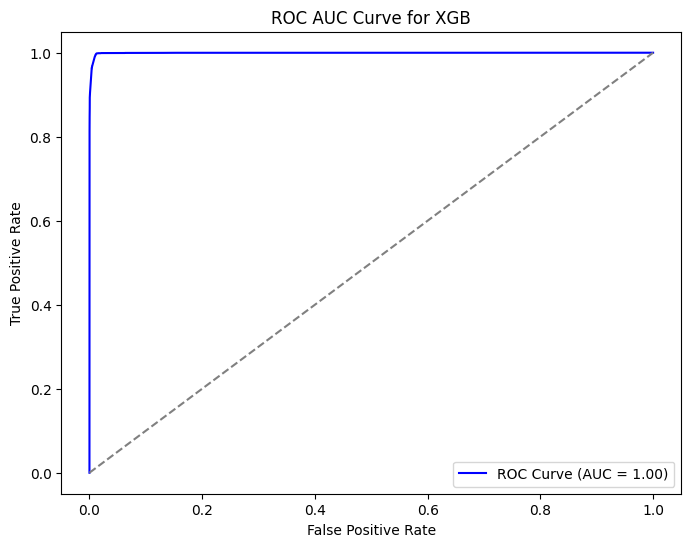

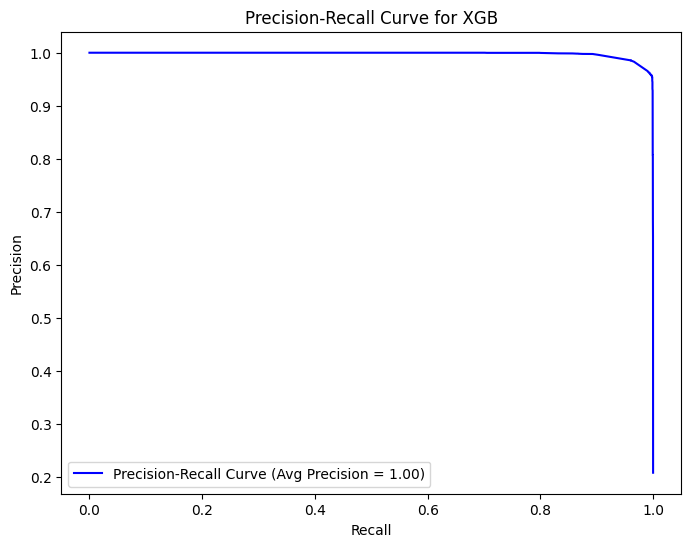

In [17]:
results = estimateResult(XGBClassifier(), X_train, y_train, X_test, y_test,'XGB')

Model doesn't seem to be overfitting

In [18]:
non_para_result = pd.DataFrame([results])

non_para_result

,Model,Accuracy,Precision,Recall,F1 Score,False Positive Rate
0,XGB,0.990478,0.962508,0.992923,0.977479,0.010164


In [19]:
# Save results to CSV
non_para_result.to_csv('normal_model_results_phase2.csv', index=False)

In [20]:
grid_search = GridSearchCV(XGBClassifier(), {'n_estimators': [50, 100]}, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

C:\Users\akash\anaconda3\envs\proj_env\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
6 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\akash\anaconda3\envs\proj_env\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\akash\anaconda3\envs\proj_env\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "C:\Users\akash\anaconda3\envs\proj_env\lib\site-packages\xgboost\sklearn.py", line 1580, in fit
    train_dmatrix, evals = _wrap_evaluation_matric

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1, param_grid={'n_estimators': [50, 100]}, scoring='f1')

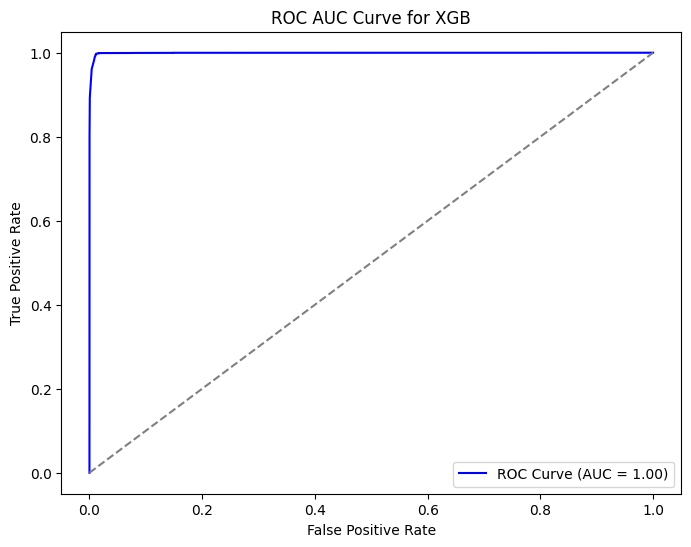

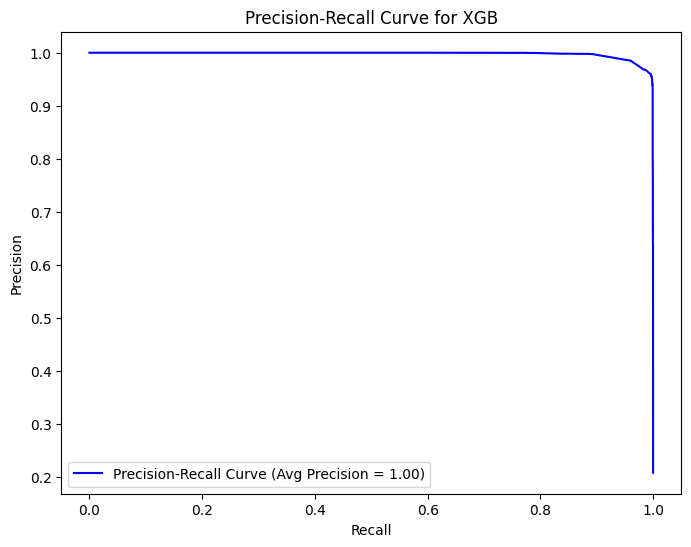

In [21]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
result = estimateResult(best_model, X_train, y_train, X_test, y_test,'XGB')

In [22]:
hyperparam_results_df = pd.DataFrame([result])

hyperparam_results_df

,Model,Accuracy,Precision,Recall,F1 Score,False Positive Rate
0,XGB,0.990341,0.966055,0.988315,0.977058,0.009126


Results don't vary much from non parameterized results

In [23]:
# Save results to CSV
hyperparam_results_df.to_csv('hyper_model_results_phase2.csv', index=False)

In [24]:
joblib.dump(best_model,'XGB_phase2_model.pkl')

['XGB_phase2_model.pkl']

In [25]:
display(best_params)

{'n_estimators': 50}